# Statistics

Compute statistics over HISCO classes, identified by OccCANINE, see `01_Classify`.

In [ ]:
from pathlib import Path
import polars as pl

base_dir = Path('.').parent
hisco_path = base_dir.joinpath('hisco_45_full_03.csv') # HISCO schema
occ_path = base_dir.joinpath('berufe_alt_LLM.csv')     # occupations with HISCO codes

In [69]:
# Group DF by HISCO1 and HISCO1+HISCO2 IDs;
# prepare lookup tables by HISCO1 and HISCO1+HISCO2 IDs.

hisco_df = pl.read_csv(hisco_path, separator=';', null_values=['NA'])
for c in hisco_df.columns:
    if not c.startswith('description'):
        continue
    hisco_df = hisco_df.drop(c)

hisco_1_df = hisco_df.group_by('hisco_1_id').first().sort('hisco_1_id')
hisco_1_df = hisco_1_df[['hisco_1_id','label1']]

hisco_12_df = hisco_df.group_by(['hisco_1_id','hisco_2_id']).first().sort(['hisco_1_id','hisco_2_id'])
hisco_12_df = hisco_12_df[['hisco_1_id','hisco_2_id','label1','label2']]

# Prepare lookup tables: 
# HISCO1 => LABEL1
# (HISCO1,HISCO2) => (LABEL1,LABEL2)
hisco1, hisco12 = {}, {}
for row in hisco_1_df.iter_rows(named=True):
    hisco1[row['hisco_1_id']] = row['label1']
for row in hisco_12_df.iter_rows(named=True):
    k = (row['hisco_1_id'],row['hisco_2_id'],)
    v = (row['label1'],row['label2'],)
    hisco12[k] = v
    
print(hisco1)
print(hisco12)

{0: 'Professional, Technical and related workers', 1: 'Professional, Technical and related workers', 2: 'Administrative and Managerial Workers', 3: 'Clerical and related workers', 4: 'Sales workers', 5: 'Service workers', 6: 'Agricultural, animal husbandry and forestry workers, fishermen and hunters', 7: 'Production and related workers, transport equipment operators and labourers', 8: 'Production and related workers, transport equipment operators and labourers', 9: 'Production and related workers, transport equipment operators and labourers'}
{(0, 1): ('Professional, Technical and related workers', 'Physical Scientists And Related Technicians'), (0, 2): ('Professional, Technical and related workers', 'Architects, Engineers And Related Technicians'), (0, 3): ('Professional, Technical and related workers', 'Architects, Engineers And Related Technicians'), (0, 4): ('Professional, Technical and related workers', "Aircraft And Ships\\' Officers"), (0, 5): ('Professional, Technical and relat

In [85]:
# Read classification results;
# match first two digits of HISCO ID with HISCO schema.
#
# HISCO IDs consist of 4 sections:
# HISCO1, HISCO2, HISCO3, HISCO45;
# the least significant section, HISCO45, may consist of a single digit, in which case if must be left-0-padded;
# e.g. 1234 becomes 12304.
#
# Extract HISCO1 and HISCO2, i.e. the two most significant IDs;
# lookup in lookup table created from schema, above.

df = pl.read_csv(occ_path)
# Slice 'hisco_1' into 'h1' and 'h2', i.e. two most significant digits.
df = df.with_columns(
    pl.col('hisco_1').str.slice(0,1).cast(pl.Int8, strict=False).alias('h1'),
    pl.col('hisco_1').str.slice(1,1).cast(pl.Int8, strict=False).alias('h2'),
    )
print(df.head())

stats = {
    'hisco1': {},
    'hisco12': {},
}
for row in df.iter_rows(named=True):
    h1, h2, d = row['h1'], row['h2'], row['desc_1']
    stats['hisco1'][h1] = (stats['hisco1'].get(h1,0) + 1)
    stats['hisco12'][(h1,h2,)] = (stats['hisco12'].get((h1,h2,),0) + 1)
print(stats)

shape: (5, 19)
┌─────┬─────────────────────────────────┬─────────┬───────────┬───┬────────┬─────────┬─────┬─────┐
│     ┆ inputs                          ┆ hisco_1 ┆ prob_1    ┆ … ┆ prob_5 ┆ desc_5  ┆ h1  ┆ h2  │
│ --- ┆ ---                             ┆ ---     ┆ ---       ┆   ┆ ---    ┆ ---     ┆ --- ┆ --- │
│ i64 ┆ str                             ┆ str     ┆ f64       ┆   ┆ str    ┆ str     ┆ i8  ┆ i8  │
╞═════╪═════════════════════════════════╪═════════╪═══════════╪═══╪════════╪═════════╪═════╪═════╡
│ 0   ┆ ge/de[SEP]pflasterer            ┆ 95160.0 ┆ 0.9881247 ┆ … ┆ null   ┆ No pred ┆ 9   ┆ 5   │
│ 1   ┆ ge/de[SEP]hilfsarbeitersehefra… ┆ 99910.0 ┆ 0.87714   ┆ … ┆ null   ┆ No pred ┆ 9   ┆ 9   │
│ 2   ┆ ge/de[SEP]hilfsarbeiter         ┆ 99910.0 ┆ 0.9799937 ┆ … ┆ null   ┆ No pred ┆ 9   ┆ 9   │
│ 3   ┆ ge/de[SEP]bauhilfsarbeiter      ┆ 99910.0 ┆ 0.999754  ┆ … ┆ null   ┆ No pred ┆ 9   ┆ 9   │
│ 4   ┆ ge/de[SEP]taglohner             ┆ 99920.0 ┆ 0.9866523 ┆ … ┆ null   ┆ No pred ┆ 9   ┆ 9

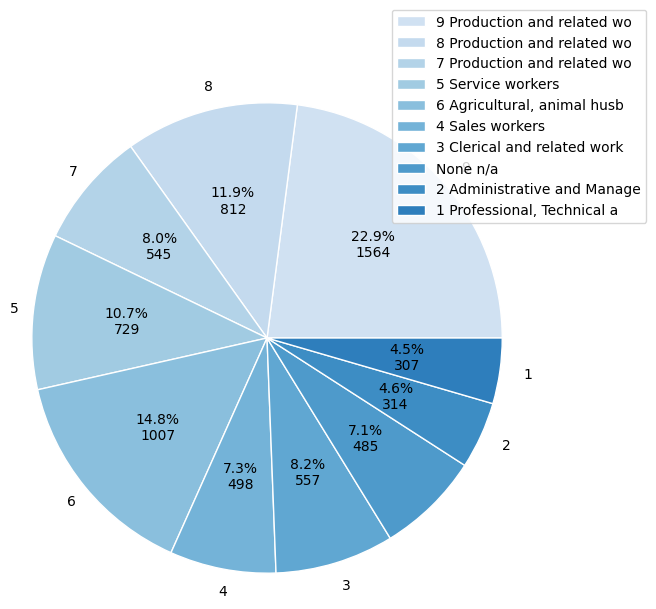

In [141]:
import matplotlib.pyplot as plt
import numpy as np


legend = [ f'{k} {hisco1.get(k,'n/a')[:25]}' for k in stats['hisco1'].keys()]
labels = stats['hisco1'].keys()
values =  list(stats['hisco1'].values())

def label_for(pct,allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n{absolute:d}"
    
# https://matplotlib.org/stable/plot_types/stats/pie.html#sphx-glr-plot-types-stats-pie-py
plt.style.use('_mpl-gallery-nogrid')
colors=plt.get_cmap('Blues')(np.linspace(0.2,0.7,len(values)))
plt.pie(values,
        colors=colors,
        radius=3,
        center=(4,4),
        wedgeprops={"linewidth":1,"edgecolor":"white"},
        labels=labels,
        autopct=lambda pct: label_for(pct,values))
plt.legend(legend, bbox_to_anchor=(1.1,1.05))
plt.savefig('/tmp/x.png',dpi=200)